# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [57]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
#added countvectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [58]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [83]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 15, alternate_sign=False)
        #cv = CountVectorizer()
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
       # print("Shape of HashingVectorizer X:")
        print("Shape of CountVectorizer x: ")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    # toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    # should it be a boolean value? As str.find returns an index; how will a boolean be converted to 0 or 1
    toxic_data['occur_fuck'] =(toxic_data['comment_text'].str.lower().str.count("fuck"))
    toxic_data['uppercase_letters'] = toxic_data['comment_text'].str.count(r'[A-Z]')
    

    X_quant_features = toxic_data[["word_count", "occur_fuck", "uppercase_letters"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [84]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='toxiccomments_train.csv', my_random_seed=65)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [85]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 13071, 'Neg': 114585, 'TP': 6629, 'TN': 55717, 'FP': 58868, 'FN': 6442, 'Accuracy': 0.48839067493889826, 'Precision': 0.10121074247675466, 'Recall': 0.5071532399969398, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [86]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13071, 'Neg': 114585, 'TP': 12819, 'TN': 114409, 'FP': 176, 'FN': 252, 'Accuracy': 0.9966472394560381, 'Precision': 0.9864563293574452, 'Recall': 0.9807206793665366, 'desc': 'svm_train'}


### MODEL: logistic regression

In [87]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13071, 'Neg': 114585, 'TP': 12946, 'TN': 114472, 'FP': 113, 'FN': 125, 'Accuracy': 0.9981356144638717, 'Precision': 0.9913469637797687, 'Recall': 0.9904368449238773, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [88]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13071, 'Neg': 114585, 'TP': 12399, 'TN': 101048, 'FP': 13537, 'FN': 672, 'Accuracy': 0.8886930500720687, 'Precision': 0.4780613818630475, 'Recall': 0.9485884783107643, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [89]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13071, 'Neg': 114585, 'TP': 12831, 'TN': 114351, 'FP': 234, 'FN': 240, 'Accuracy': 0.996286896033089, 'Precision': 0.982089552238806, 'Recall': 0.9816387422538444, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [90]:
from sklearn import linear_model
#try small numbers 0.1 or something
#try multiple ridge models
rdg01 = linear_model.RidgeClassifier()
rdg01.fit(X_train, y_train)

rdg01_performance_train = BinaryClassificationPerformance(rdg01.predict(X_train), y_train, 'rdg01_train')
rdg01_performance_train.compute_measures()
print(rdg01_performance_train.performance_measures)

{'Pos': 13071, 'Neg': 114585, 'TP': 9848, 'TN': 114244, 'FP': 341, 'FN': 3223, 'Accuracy': 0.9720812182741116, 'Precision': 0.9665325350868583, 'Recall': 0.753423609517252, 'desc': 'rdg01_train'}


In [91]:

#try small numbers 0.1 or something
#try multiple ridge models
rdg02 = linear_model.RidgeClassifier(alpha=0.034)
rdg02.fit(X_train, y_train)

rdg02_performance_train = BinaryClassificationPerformance(rdg02.predict(X_train), y_train, 'rdg02_train')
rdg02_performance_train.compute_measures()
print(rdg02_performance_train.performance_measures)

{'Pos': 13071, 'Neg': 114585, 'TP': 9846, 'TN': 114244, 'FP': 341, 'FN': 3225, 'Accuracy': 0.972065551168766, 'Precision': 0.9665259644645136, 'Recall': 0.753270599036034, 'desc': 'rdg02_train'}


In [92]:

rdg03 = linear_model.RidgeClassifier(alpha=0.15)
rdg03.fit(X_train, y_train)

rdg03_performance_train = BinaryClassificationPerformance(rdg03.predict(X_train), y_train, 'rdg03_train')
rdg03_performance_train.compute_measures()
print(rdg03_performance_train.performance_measures)


{'Pos': 13071, 'Neg': 114585, 'TP': 9848, 'TN': 114244, 'FP': 341, 'FN': 3223, 'Accuracy': 0.9720812182741116, 'Precision': 0.9665325350868583, 'Recall': 0.753423609517252, 'desc': 'rdg03_train'}


In [93]:

rdg04 = linear_model.RidgeClassifier(alpha=0.35)
rdg04.fit(X_train, y_train)

rdg04_performance_train = BinaryClassificationPerformance(rdg04.predict(X_train), y_train, 'rdg04_train')
rdg04_performance_train.compute_measures()
print(rdg04_performance_train.performance_measures)



{'Pos': 13071, 'Neg': 114585, 'TP': 9846, 'TN': 114244, 'FP': 341, 'FN': 3225, 'Accuracy': 0.972065551168766, 'Precision': 0.9665259644645136, 'Recall': 0.753270599036034, 'desc': 'rdg04_train'}


In [94]:

rdg05 = linear_model.RidgeClassifier(alpha=1.25)
rdg05.fit(X_train, y_train)

rdg05_performance_train = BinaryClassificationPerformance(rdg04.predict(X_train), y_train, 'rdg05_train')
rdg05_performance_train.compute_measures()
print(rdg05_performance_train.performance_measures)



{'Pos': 13071, 'Neg': 114585, 'TP': 9846, 'TN': 114244, 'FP': 341, 'FN': 3225, 'Accuracy': 0.972065551168766, 'Precision': 0.9665259644645136, 'Recall': 0.753270599036034, 'desc': 'rdg05_train'}


### MODEL: Random Forest Classifier

In [95]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 13071, 'Neg': 114585, 'TP': 0, 'TN': 114585, 'FP': 0, 'FN': 13071, 'Accuracy': 0.8976076330137244, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


C:\Users\jills\Documents\Machine Learning\ml\final_assignment_1\my_measures.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

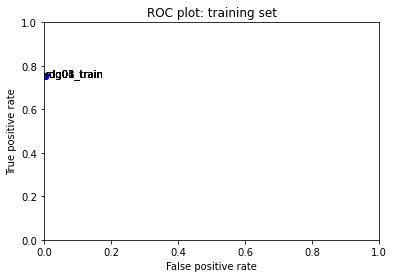

In [100]:
fits = [rdg01_performance_train,rdg02_performance_train,rdg03_performance_train,rdg04_performance_train,rdg05_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [101]:
ols_predictions = ols.predict(X_train)

In [102]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
22
Please do not remove warnings from users page
* * * * * * * * * 
56
Given his lack of repentance, or even acknowledgement of the (ongoing) problems with his editing behaviour, I have taken your advice and started an ANI request, here.  I would appreciate your input, as both an experienced editor and as an admin.  I've thankfully never had to do this before, and am unfamiliar with the process.
* * * * * * * * * 
59
Blocking

I think I was blocked under a idea which is ludacris, just because I gave my opinion about somneones idea and contributed to a few articles doesn't meany you should call me a troll. People like Sukh and Ramas Arrow could be called trolls sinces all they do is stay at the Sikhism page.

16 July 2006 (UTC)
* * * * * * * * * 
71
Glad 

I really am glad that you have finally come to your senses and largely given up. You're persistent over use of wikipedia guidelines to mask your own agenda-driven violations of WP:IDL, WP:OWN and WP:NPOV m

5082
Hah, given away by their own web service!  He didn't even scroll down, but the screen showing a comparison of revisions was on the screen for so little time it didn't register.
* * * * * * * * * 
5180
Hello, welcome to Wikipedia.

You might find these links helpful in creating new pages or helping with the above tasks: How to edit a page, How to write a great article, Naming conventions, Manual of Style. You should read our policies at some point too.

If you have any questions, see the help pages, add a question to the village pump or ask me on my talk page. If you made any edits before you got an account, you might be interested in assigning those to your username. I hope you enjoy editing here and being a Wikipedian!

. 00:11, Feb 3, 2004 (UTC)
* * * * * * * * * 
5186
"

Spellings
Ah, good question - there's quite a few (doubtless a result of the European tongue trying to wrap itself around asian words). Francois Bernier spelt it ""Tage Mehale"" other alternatives might be ""Ta

9439
"
 You present a fundamental misunderstanding of anarchism. Anarchists do not reject the opinion of learned people; they reject their being promoted to positions of authority. ""Sensible"" would be what a web accessibility standard prescribes. Not sensible would be for the aesthetic sensibilities of people who are not experts to predominate.   "
* * * * * * * * * 
9487
"::I reaffirm my position that the irresponsible publication of the unverified claims of the DI as if they were established facts is potentially libelous and a prima facie violation of the WP:BLP ""Do No Harm"" clause.  There are 102 other people who are in a similar situation.  

The analysis of the 2001 ad by Skip Evans establishes reasonable doubt that the claims of the DI are factually correct.  

 

"
* * * * * * * * * 
9559
"
A massacre requires deliberate intention and is often seen as a planned event. Please note that De Waal says, ""I do not think that it was a deliberate action, approved on, I think it was

12844
Yea, I know, so can I finally create the Jeff Moita article then?
* * * * * * * * * 
12900
"
Promontory Point article
Sure, bring up your concerns and I'll try to address them. As for not being a Hyde Parker, though... here is the view from the window that I am literally 6 inches away from as I type this. (Also, please remember to sign your talk posts! Thanks.) — ☠ "
* * * * * * * * * 
12952
I think we need more pictures (99.226.69.43  )
* * * * * * * * * 
12978
"==GA Review==
:This review is transcluded from Talk:Care Bears Movie II: A New Generation/GA1. The edit link for this section can be used to add comments to the review.

Reviewer: Freak 
GA review (see here for criteria)

It is reasonably well written.
a (prose):  b (MoS for lead, layout, word choice, fiction, and lists): 
 
It is factually accurate and verifiable.
a (references):  b (citations to reliable sources):  c (OR): 
 
It is broad in its coverage.
a (major aspects):  b (focused): 
 
It follows the neutral point 

16023
"

 When leaveing a messsage 

Don't post it on my user page I have a talk page for a reason.eagle "
* * * * * * * * * 
16051
)

User talk:Dormskirk/Archive 2 (2013-2015
* * * * * * * * * 
16053
"

Why? I only redirected ""Sahanx"". What other use has Wikipedia got for the article ""Sahanx""? - "
* * * * * * * * * 
16083
I have been trying very hard to follow policy but this has drawn me heavy criticism; I feel Ryan is openly hostile towards me and i dont think direct discussion is an appropriate avenue; i am not interested in an apology as this does not prevent him from future misconduct. I feel it is appropraite to attempt arbcom because it feels to me like administrators are generally ganging up on me, criticizing my attempts to follow policy, and negrelcting policy themselves. since arbcom is a serious panel i would readily accept their judgment and any consequences against myself as final; this has been a nightmare that has drained days of time and i would not consider this 

18558
B class article Comparison between Han and Roman Empires 

I think this article is pretty B class. How does it not meet B class criteria?
* * * * * * * * * 
18576
Oh, I didn't say it wasn't. I just have a little doubt, that's all. It might just be possible that the book was compiled by people who aren't completely neutral on the subject of homophobia - I mean people who might themselves be potential (ot even actual) victims of homophobia, and a book of their hand might include certain biases.
* * * * * * * * * 
18622
"
Sorry, I couldn't quite remember precisely what you said, nor where you said it, so was careful not to directly attribute this to you. I understood you to be giving an opinion on the likely view taken by others, not that this was an instruction from you to me. But I remembered taking a very strict interpretation of what you said;

The strictest interpretation I regarded they would take was, ""a problem if you were editing and picking up new projects"". I therefore 

21714
13/3/06  i have split this page from
* * * * * * * * * 
21717
"
I'll do 1 point for copy-editing but you only score the point once for each article. Not per each copy-edit to a single article if that is what you are saying. As for representing New York, I'll put you down as USA and if you want to change to New York we can deal with that later.   the legend reborn... "
* * * * * * * * * 
21839
":The wording that was reverted was as follows:


Northern Ireland (, Ulster Scots: Norlin Airlann) is a part of the United Kingdom of Great Britain and Northern Ireland[2]...

2 In common with the other constituent parts of the United Kingdom, Northern Ireland is sometimes referred to as a ""country"" (example). The UK government also refers specifically to Northern Ireland as being a ""province"" (UK: example; NI: example) or a ""region"" (UK: example; NI: example). Regardless of the choice of term, it is likely to be unsatisfactory and can imply a preferred political perspective:
 ""One p

24880
, 2 July 2008 (UTC)
 Talk of scientific principles is pseudoscience which was discarded in the Renaissance.  Modern science is essentially empirical - it makes experiments and observations.  Theories and principles are secondary and must follow these results whither they lead, whether they make sense or not.  In medicine, simple mechanistic ideas do not suffice to explain many observations.  For example, if you give someone an emetic in a certain way then it is found to have the opposite effect of preventing nausea.  It seems that the doctor-patient relationship plays a considerable part in this and it may be that homeopathy is especially efficacious in this regard.  Our lede should not be dogmatic when the matter is not fully understood.   13:06
* * * * * * * * * 
24901
She has gotten pretty significant media coverage. So even if she did lose, her article should remain.
* * * * * * * * * 
24908
"

 Speedy deletion of ""Boogeyman 3 (film)"" 

 A page you created, Boogeyman 3 (fil

28869
File:PICT4088.JPG listed at Redirects for discussion 
An editor has asked for a discussion to address the redirect File:PICT4088.JPG. Since you had some involvement with the File:PICT4088.JPG redirect, you might want to participate in the redirect discussion (if you have not already done so).
* * * * * * * * * 
28955
"
I'll show you the relevance of them,
WP:AN3#User:Geoeg reported by User:dicklyon (Result: Both blocked for 6 hours) dicklyon and Geoeg have been disagreeing about an article where WP:COI is a concern. Since dicklyon reported Geoeg for 3RR, he/she is focusing negative attention on Geoeg. Why is this not harassment?
WP:AN/I#SPA Milto LOL pia pointed out a concern about a WP:SPA editor, also focusing negative attention on them. Why is this not harassment?
WP:COIN#SPAs and socks pushing POV, PR, and advertising on the Chapman_University_School_of_Law Page This also focuses negative attention, not totally unlike what I said Justanother has done. Why is this not harassme

32594
"*I'd still like a compromise like the one used in the Vietnamese article: ""Linguafranc"" (Tiếng Nhật: リンガ・フランカ Ringa Furanka, Tiếng Anh: Lingua franca)! That means as seen in the Vietnamese article, I'd like the original Japanese title due to the fact it's the only officially given song title (by both labels). Additionaly, I'd like to acknowledge that some people know the song by linguafranc no matter whether it is a misspelling, a fan title or not. Plus, I'd like the correct English term Lingua Franca displayed because it's de facto the correct English term and English translation for the Japanese title as well as what is officially used (by composer etc.). That would be something like this: リンガ・フランカ (romanization: Ringa Furanka; English: Lingua Franca; largely known as: linguafranc). As far as I can see * and I are for this compromise while * and * seemingly are against any compromise/consensus in favor of enforcing their personal believes. Did I get each faction right?   

"

36141
To me the user who has blocked me has gone wrong somewhere along the line, is your proof I sent an email to CUTKD ( a confessed Hamish Ross sock) through wiki? He was a good friend on here up to when he started attacking. I have never and will never be anything to do with sockpuppetry and don't use proxy rubbish IPs
* * * * * * * * * 
36189
WikiProject Thoroughbred racing |class=stub |importance=
* * * * * * * * * 
36214
Emtjets Charter Marketplace offers direct access to Brokers and Charter Companies Worldwide.Private Jet Charter, Air Charter Flights, Empty Legs, Air Freight and .private jet.
* * * * * * * * * 
36227
killings of civilians 

Should be made clear in the information template that killings of civilians as a result of battles and Houthi forces in favor of and against the tribes of Shabwa and Marib and Southern Movement
* * * * * * * * * 
36247
The current map 

The current map shows the Isle of Man and Channel Islands as though they are part of the UK, which they are

40204
Merge to Insulated glazing  
It appears that this article only applies to Insulated glazing, and the content here is no longer than what is already in the appropriate section there. —
* * * * * * * * * 
40298
"

 Please stop adding inappropriate external links to Wikipedia, as you did to Surdas with this edit. It is considered spamming and Wikipedia is not a vehicle for advertising or promotion. Because Wikipedia uses nofollow tags, additions of links to Wikipedia will not alter search engine rankings. If you continue spamming, you may be blocked from editing Wikipedia. Thank you.   "
* * * * * * * * * 
40327
Have I been blocked yet?  Fatuorum
* * * * * * * * * 
40401
Setanta 

A reference would help as there's no mention of League of Ireland coverage on Setanta Ireland's website, just SS. Cup coverage. When did they last show a LOI game?
* * * * * * * * * 
40519
OH really?? 19 years old is not that young for Chess. And your hope is far far away from the mastery of Levon Aronian 

43382
"

Please go right now and read Wikipedia policy.  You must treat other users with respect and not address them in such a confrontational tone.  Do not insinuate that they are morons for taking certain positions on this issue.
Now, to your point.  No one is claiming that the image of Muhammad is any more ""real"" than the image of Qin Shi Huang.  They are both done in later times to represent an historical figure.  Muslims do have a tradition of representing the prophet in images even if it is not the most prevalent.  What the image on the page represents is part of the tradition that Muslims have in representing Muhammad.  Now, feel free to enter into discussion about whether or not you believe such images are important enough to warrant inclusion on Muhammad but make sure you are arguing about depictions in Muslim tradition and not merely your own personal feelings.  Also note that Depictions of Muhammad (AVOID if you will be offended) has various images of MuhammadMuslim and n

46398
Hi, please read WP:NOT#Wikipedia_is_not_a_mirror_or_a_repository_of_links.2C_images.2C_or_media_files. Thanks, 1
* * * * * * * * * 
46476
For an Authentic account of India's untouchables refer National Geographic article 05:51, 31 July 2006 (UTC
* * * * * * * * * 
46525
Frankly, I would think that would be true of any individual athlete, but you have to see the level of detail in these athlete season articles to believe it.  It puts to shame the legendary baseball fan OCD fascination with stats.  LOL
* * * * * * * * * 
46566
"

I really don't care all that much about the Jewish lists and categories.  I've voted on some of them, mostly because other editors have solicited my input (I think with more confidence in what I would opine than is merited).  My votes on those have been mixed, and have depended on how specific the topics are, and whether I think they can be done in an encyclopedic fashion.  But I'm neither one of those people who votes ""keep"" for anything with the word "

50020
Reopened to see if any other admins will do it for me.  (talk | )
* * * * * * * * * 
50054
Re:How to cross-wiki images? 

Good news for you: since all the images at the Spanish wikipedia are placed in commons:. there is no need to cross reference them, you just use them! Just be careful to change Imagen with Image.

A not though on the naming of the articles. Except for provincial capitals, the default convention is to name cities and towns with their name only. If there is an ambiguity (e.i. Carlos Pellegrini is also a former-president), then you add the Province's name after a comma:
Carlos Pellegrini, Santa Fe.

If you wish, you can use the City Templates we commonly use in Argentine cities; check Rosario for the full use of the templates.

Don't hassitate to contact me if you have any other doubts. Good wiking, (t/c)
* * * * * * * * * 
50121
"

I have been thinking about this for a while. Isn't practically everyone required to make some noise at at least every 4 minutes 33 se

53090
take in our waveform snippet)
* * * * * * * * * 
53183
What is the history of 'delete'?
* * * * * * * * * 
53193
"
Sources, evidence? I'd love to add that fact, but it's the first I've heard of it. I listened to a long story on NPR on waterboarding last night, and there was no mention of this, and I don't recall reading about it in any of our various articles (unless I just lost it in the shuffle). Link?  "
* * * * * * * * * 
53287
"

 Hi,
 You are probably right, I should have asked for a source rather than calling it ""drivel"".  I can't say I know a lot about Proust, but I remember him being described as a hypochondriac, so I'm easily convinced regarding odd description of that author.  However, the addition in question certainly did require a citation:
 It is also said that Proust, who, for a time owned a brothel, would enjoy watching young male prostitutes engaging in their trade. It is also said, however, that watching hungry caged rats fight each other to the death or tort

56068
"==Atlantic campaign of May 1794==
Thankyou for your GA review, I think you have done a great job and thanks to your input the article has improved greatly. I'm sorry that there was all that misunderstanding earlier, I never meant to imply you were stupid and I'm sorry if it sounded like that. You are a concientious editor and you've done a good job. Thankyou and all the best.  

Fair use rationale for Image:Verbir.jpg
Thanks for uploading or contributing to Image:Verbir.jpg. I notice the image page specifies that the image is being used under fair use but there is not a suitable explanation or rationale as to why each specific use in Wikipedia constitutes fair use. Please go to the image description page and edit it to include a fair use rationale.

If you have uploaded other fair use media, consider checking that you have specified the fair use rationale on those pages too. You can find a list of 'image' pages you have edited by clicking on the ""my contributions"" link (it is 

60203
"

 Arthur Morris FAC 
Hi there Rambling Man. I'm Hoping to regain some momentum on the Invincibles FT. Please have a look. Thanks, ''''  (bananabucket'') "
* * * * * * * * * 
60217
Thanks 

Hi David,

Thanks for taking the time to write such a thoughtful analyis at Talk:DepoProvera. (And for reminding me it's Guy Fawkes!)

I feel that I don't need to assure you that I will not be offended in any way if you restate your position from our earlier discussion re Pfizer/LaCroix/BMD in the current disputebut just in case, please be assured that I will not.  It might actually be helpful to have other people than Mastcell and I making the argumentsperhaps more input should be solicited elsewhere, as well, if not enough editors contribute in a week or two week's time.

I will be slow-to-respond/disengaged on the Depo talkpage, in hopes of keeping things cool, while still continuing to advance the discussion. There is no hurry and deadline, after all.:-)

I don't know if you've been follo

64239
Hi A.B. Thanks for the supporting messages on my discussion page. My first page Universal Powerline Association. I am concerned because eliminating this page and not eliminating the alternative page for HomePlug would cause a NPOV problem. I am mystified. Can you advise how to move forward?
* * * * * * * * * 
64245
"

Not really requesting an unblock, because I'm not sure there's any point to continue editing Wikipedia, if the ""winners"" in disputes are the ones who are pushing a years-long agenda and manipulating content so that it reads as defamatory as possible, without any corroborating documentation besides Archive.org/Oregon website; and the ""losers"" are those who do all the hard work to expose the manipulators who are themselves socking, themselves lying.  I merely hope that one of the other editors operating in the right will bring this tag-team to the Administrators Noticeboard, because the chicanery needs to stop.    "
* * * * * * * * * 
64285
Of course, it is always

67172
Image:Cirillo.jpg 
Hi, Thank you for uploading Image:Cirillo.jpg,however it would be much appreciated if you could expand or clarify the sourcing information you have provided in the image summary.
* * * * * * * * * 
67218
Sudhan 

I saw your comments concering the editors on this article, as you can see, I asked both editors to put there arguments on the talk page, rather than just deleting everything, both editors dont think that is necessary, now they went to my other article and put the notability thing on it, even though that was already decided in 2010,  See Ghulam Ahmad (engineer).

So I am not sure what else i am supposed to do.  Maybe you can look at the article Sudhan and decide for yourself, one editor all he did was google sudhan and go the government of AJK website.

looking forward to  your reply
* * * * * * * * * 
67238
"
As I suspected, complete nonsense. Your statement is so silly that I can't begin to tell you how wrong it is. You said, ""You there presume that 

70197
"

 Riddled with errors 
If it's going to be locked at least sort the spelling and typos out. ""show trails"", ""sentance"" - come on! Anon-ish"
* * * * * * * * * 
70363
Source of the story 

ive made some minor changes to the paragraph, it isn't questioned as a source for hadith, it isn't accepted outright as a source of legislation since the only source is Ibn Ishaqs history. no history irrespective of the author is used for doctrine in Islam and all works of history take a back stage in terms of authenticity [since historians did not bother to document their works] to the works of hadith literature such as bukhari. the current phrasing made it seem as if their existed a dispute between various scholarly schools of thought regarding the narration which doesn't exist, the grading of this narration is unanimous since it never made it into any works of hadith literature. The wording also seemed apologetic which Muslim scholars would never have been regarding the actions of the pro

74176
. Also, you can ask PaxEquilibrium, another Montenegrin user, if Slobodan Milošević and Vuk Karadžić are Montenegrins by origin
* * * * * * * * * 
74245
Joe Dirt

Should it be notable that KXLA was the call sign for the fictional 98.6 KXLA in the film Joe Dirt?
* * * * * * * * * 
74286
"

Pending changes
This article is one of a  number selected for the early stage of the trial of the Wikipedia:Pending Changes system on the English language Wikipedia. All the articles listed at Wikipedia:Pending changes/Queue   are being considered for level 1 pending changes protection.

The following request appears on that page:

Comments on the suitability of theis page for ""Pending changes""  would be appreciated.

Please update the Queue page as appropriate.

Note that I am not involved in this project any much more than any other editor, just posting these notes since it is quite a big change, potentially

Regards,  Farmbrough, ."
* * * * * * * * * 
74323
I've tried my best to prevent van

77030
True enough. Cromartie is a regular. He is in almost every episode, and he's listed as a minor character, for a good reason. He's no starring character. Derek Reese, although in almost every episode, is also more of a side character.
* * * * * * * * * 
77048
thank you very much for your answer. happy new year !!!
* * * * * * * * * 
77060
Err.. no, there really is'nt any objectionable content on this show.  Are you thinking of Beavis and Butthead?
* * * * * * * * * 
77170
I have to say I disagree a little bit on the Colorado and Michigan State games. Appalachian State definitely deserves mentioning, but Colorado and Michigan State, while both having great and interesting finishes, are not important enough to be mentioned in the header, particularly when you combine it with the absence of the 1945 Army game, and the 1969 and 2006 Ohio State-Michigan games, the '69 game in particular because Woody admitted that was his best team and the Wolverines cost the Buckeyes what would have s

80049
User: Pashute Dear Sir, the events surrounding Jobar are highly complex. The dating of the destruction is largely dependent upon posts from SY on Twitter. There is no connection with Yom Yerushalaim, as you write. The Sotheby's sale was in any event in Dec of the previous year. I have not seen any artefacts from Jobar on sale (to the public) otherwise. I am not very familiar with the editing on Wikipedia (though I may request your help and advice if I may). I'm also happy to correspond more extensively at my email address adam.blitzATcolumnist.com on the topic (when you will receive much more prompt responses). Thanks and regards AB
* * * * * * * * * 
80059
) (note: this comment was edited by its authour AFTER it was replied to
* * * * * * * * * 
80217
"

Hi, RyanGerbil10.  Thank you for explaining the block placed on my account.  I have reviewed both WP:stalk and WP:NPA policies and I do not believe the actions you speak of are in violation of either of these policies, nor do I 

83932
is also automatically watched by you)
* * * * * * * * * 
83959
On the alternative education article, they didn't mentioned special schools but it mentioned on the top in alternative school.
* * * * * * * * * 
84005
Removed from article: 
An extra-large common pork sausage was named after him.  

Nah.
* * * * * * * * * 
84087
Earliest appearance?
The Pinapple bun is at least 70 years old, according to the article. How far back can we trace Melon pan?
* * * * * * * * * 
84169
Deanna Cortese is Italian-American as well so please update.
* * * * * * * * * 
84176
"

 Theoretical justification for our tax system? 

I added this sentence to the lede...

""The two main theories of taxation are the benefit theory and the ability to pay theory.""

...which ‎Guest2625 removed with the explanation that this entry doesn't contain the ""terms"" used in my sentence.  

There's a theoretical explanation for the world's current tax system...either that or we're all crazy.  If you're saying that t

86958
It is a term used in the John F. Kennedy article
* * * * * * * * * 
87075
"

Speedy deletion of Andrew takao
 A tag has been placed on Andrew takao requesting that it be speedily deleted from Wikipedia. This has been done under section A7 of the criteria for speedy deletion, because the article appears to be about a person or group of people, but it does not indicate how or why the subject is notable: that is, why an article about that subject should be included in an encyclopedia. Under the criteria for speedy deletion, articles that do not indicate the subject's importance or significance may be deleted at any time. Please see the guidelines for what is generally accepted as notable, as well as our subject-specific notability guideline for biographies. 

If you think that this notice was placed here in error, you may contest the deletion by adding  to the top of the page (just below the existing speedy deletion or ""db"" tag), coupled with adding a note on the talk page explain

89317
So, here's a pargraph I deleted:

Potential Republican candidates include 2006 nominee and businessman Dick DeVos, state Attorney General Mike Cox, Congressman Pete Hoekstra, state Secretary of State Terri Lynn Land, Congresswoman Candice Miller, state Senate Majority Leader Mike Bishop

All those people have said to news sources they aren't running/are/or something related? Or am I confused?
* * * * * * * * * 
89332
"

 Please do not vandalize pages, as you did with this edit to Nuclear medicine. If you continue to do so, you will be blocked from editing.  [T@lk/Improve] "
* * * * * * * * * 
89344
It's already written, just in a separate article. See In the Groove (series)#Common Gameplay Elements. (ζ)
* * * * * * * * * 
89421
"

 Prior accounts 

Have you ever used a prior account on Wikipedia? nableezy - "
* * * * * * * * * 
89433
"

 Maybe leaving? 

My best friend on Wikipedia just left & I'm kinda depressed. Don't know if I'm gonna stay here. All my ""friends"" never messag

93091
That works, thanks.
* * * * * * * * * 
93095
"Wikipedia has a reputation for being a joke on anything that doesn't comply with the leftist extremist fringe. You have a Black Supremacist on this talk page speaking about alleged associations with ""White supremacy"". How hilarious is that? 173.34.108.86  

"
* * * * * * * * * 
93195
Thank you for your efforts.

I for one thank you for your efforts in sticking with the Rajput page and although a lot of baseless unpleasantries were focussed on you by the extremist Hindus, I am sure the real Hindu brothers and sister on Wikipedia saw through the real genuine effort you displayed in trying to resolve this difficult issue. The arbitration is over and Im glad the result was seen for what it was, a bunch of childish bigots not prepared to work with others for the betterment of enlightening others on our culture and traditions. Unfortunately, I think Rajputs are now seen more as a quarelling bunch rather than what we try and say we are, lo

95954
why do you undo me? 

bro.. ot erase y information on noahs ark... i just put what it is on the bible no lie on it. read and yo'll see.
* * * * * * * * * 
95955
If we were to delete every character article that isn't as iconic as Superman, there'd be barely anyone left. The characters I left up have all appeared in two or three films, are all fairly popular and it shouldn't be too hard to find a number of external sources about them, which I will try to do once I have the time.
* * * * * * * * * 
95988
Some personal observations here: 
Put a summary of it into the Roots of Christianity; perhaps a whole subsection thereof.  If the Zoroastrianism part is included, then so must the Egyptian especially since the Hebrews were long associated with Egypt back to the Hyksos invasion.  It would be POV to disclude this factor, considering the trail of monotheism left by Akhenaten and adopted by the Hebrews.  I myself don't know much about Zoroaster, but I certainly recognise much of the Eg

98833
, 14 February 2007 (UTC) 03:09
* * * * * * * * * 
98854
Welcome!

Hello, , and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are some pages that you might find helpful:
The five pillars of Wikipedia
How to edit a page
Help pages
Tutorial
How to write a great article
Manual of Style
I hope you enjoy editing here and being a Wikipedian! Please sign your name on talk pages using four tildes (~~~~); this will automatically produce your name and the date. If you need help, check out Wikipedia:Questions, ask me on my talk page, or place {{helpme}} on your talk page and someone will show up shortly to answer your questions. Again, welcome!
* * * * * * * * * 
98883
Problems with 6.5 metre an Ton classes 1900 

Salut Ned ! Please have a look to [[fr:Jauge Godinet] about Ton classes in Olympics 1900, and fr:6.5m SI for 6.5 Metre which is not according to International Metre Rule, but to a french rule (Jauge chemin de fer) (Railwa

101917
"

 Need a name or such 

I stubbed together a couple of informational and display ?Essays, ?Demonstrations, ?________ pages... whatever... Wikipedia:Neutrality_templates, and Wikipedia:Dispute templates due to  a double dose of reverting editors, so I can point to inline templates as better ways to handle disputed lines, paragraphs, etc. So what the heck are such called? Seems like a logical extension of 'main article' tagging on cats, so I cross tagged the categories... So what do I call these non-guidelines, non-policies, non-project, non-essay samplings of available choices. Menu pages!?? HAH! Being an organizing guru of sorts, I figure you're a good resource to ask. While you ponder that, have a happy new year! Thanks // nkB  

Hmmmmmm... WP:NT Darnused already!'  and WP:DT (good, arguably the more important one to cite) Cheers! // nkB"
* * * * * * * * * 
101921
Honestly, Olaf, the POV fork argument just doesn't hold water. Look at Criticism of Christianity, Criticism of Is

104789
"

""Originally conceived as a bonus disc to accompany a reissue of The Fame, her four million-selling debut album, Monster is now being released as a record in its own right. ""In the midst of my creative journey composing The Fame Monster, there came an exciting revelation that this was in fact my sophomore album,"" the Lady herself explains. ""It's a complete conceptual and musical body of work that can stand on its own two feet."" "
* * * * * * * * * 
104794
HELP!!

wow i added to the history section and i'm not sure what i did but can some one please help me!!!
* * * * * * * * * 
104812
Article cites references through ApiDays and SpringOne which are sources external from self; this is typical for research and software to have other sources site their work. To remove this based on fact that references from other software sources,vendors, conferences, etc are not significant would mean you would have to remove 90% of software, research, patterns, etc from wikipedia.
* * * * 

109052
...also this is coming up
* * * * * * * * * 
109075
I told you, I searched ONLY English-language pages. I am familiar with the word because I do proofread old books (18th and 19th century) for Distributed Proofreaders. Just because you don't know the word doesn't mean that it wasn't used.
* * * * * * * * * 
109076
"  — Preceding unsigned comment added by  "
* * * * * * * * * 
109125
"

I have answered your comment on my talk page, if you're interested, although apparently you're far too hot-headed to listen to reason and discuss like a normal, mature individual.  I'm sorry you are not able to communicate. —·?·!·@ "
* * * * * * * * * 
109161
Ditmas Junior High School 62
* * * * * * * * * 
109244
"

You forget we some times keep entire litters. YOU assume we sell them all...which is incorrect. What you don't realize is a serious breeding program has to keep a number of dogs from every litter for evaluation purposes. Like I said...I am not a dog breeder for ""business."" It is a pa

112440
Ah, thank you for the tip.
* * * * * * * * * 
112579
May 2013
Are you being secretly sexist?  I just completely updated California Historical Landmarks in San Francisco, California and you sent me that message?
* * * * * * * * * 
112581
You have not read that discussion correctly. Forget the closing remarks: the usage was deemed not to meet our policies. -
* * * * * * * * * 
112679
I believe he immmediately went on a tour of Georgia once accepting the UGA job to promote the school and recruit students and became ill during those travels before coming back to Athens.  If you have not done so already, check out History of the University of Georgia by Thomas Walter Reed; Frontmatter and Chapter I: The Beginnings of the University, Thomas Walter Reed,  Imprint:  Athens, Georgia  University of Georgia, ca. 1949. It states he took part in the commencement in the spring and then started his PR tour.  That source also indicates that the UGA Board of Trustees was actively recruiting Finl

115386
"
How is it a ""personal attack"" to point out that 67.168.135.107  "
* * * * * * * * * 
115389
Yannick Salem appearances/goals 

Are bogus and made up.
* * * * * * * * * 
115405
reolution 585p/720p
why is there no resolution in the infobox? is it because it is SD (585) like Halo 3 and Haze or some?
* * * * * * * * * 
115428
Welcome!

Hello, Director.sara, and welcome to Wikipedia! Thank you for your contributions.

I notice that one of the first articles you edited  appears to be dealing with a topic with which you may have a conflict of interest. In other words, you may find it difficult to write about that topic in a neutral and objective way, because you are, work for, or represent, the subject of that article. Your recent contributions may have already been undone for this very reason. 

To reduce the chances of your contributions being undone, you might like to draft your revised article before submission, and then ask me or any other editor to proofread it. See our help p

117923
Not unreferenced not BLP 

Hi  - the article was not unreferenced (sourced to the 1911 EB), and definately not a BLP.
* * * * * * * * * 
117939
From Nuclear explosion:
In 1945 there was some initial speculation among the scientists developing the first nuclear weapons that there might be a possibility of igniting the earth's atmosphere with a large enough nuclear explosion. This would concern a nuclear reaction of two nitrogen atoms forming a carbon and an oxygen atom, with release of energy. This energy would heat up the remaining nitrogen enough to keep the reaction going until all nitrogen were finished. This was, however, quickly shown to be unlikely enough to be considered impossible . Nevertheless, the notion has persisted as a rumor for many years.
* * * * * * * * * 
118087
The Aiken page went through several months of editing and mediation before consensus was reached on the current version.  The current version indeed mentions the tabloid stories, even if they are not t

120538
All sources seem to indicate that the first practical solutions to anti-aliasing were invented Frank Crow, computer graphics pioneer (who incidentally works for nVIDIA these days), in 1977.  Earliest reference I could find was: The Aliasing Problem in Computer-Generated Shaded Images, Communications of the ACM, vol. 20(11), pp 799-805. Nov. 1997.  Of course I've also seen mentions of work done at the Architecture Machine Group at MIT in 1972, but I have not seen any references to published papers.  23:06 Jan 24, 2003 (UTC)
* * * * * * * * * 
120625
That is because most iPod owners do not know about other Portable Music Players.
The Transcend Tsonic is more popular than the iPod in many places.
* * * * * * * * * 
120714
Please don't remove NPOV tags; doing so is considered vandalism.
* * * * * * * * * 
120739
"

 FC Bayern edits 

I removed Julian Green, Fabian Benko, Gianluca Gaudino and Ivan Lucic as they don't play for FC Bayern.  They play for FC Bayern II.  While they are on

123129
SA 

I'm right and you're wrong. Read the wikipedia guidelines.
* * * * * * * * * 
123153
"

The above paragraph was written by a discredited and inactive user. His account no longer exists. As mentioned before: There is no evidence of ""Yeehaw"" being used to control the direction of draft animals. There is, however, copious evidence of ""Gee & Haw"" used for directing animals, but there is no connection between the two phrases.   "
* * * * * * * * * 
123162
I pretty much agree. In fact I was just linking Kode9 because I saw the ref when reading the entry page and I know he has a page. Kode9 and Dubstep are certainly both notable, and the inspiration of Ballard is quite interesting, but is probably a good subject for a magazine article, not a Wikipedia one. Certainly, more POV than it should be. I think many good articles are spoiled by vainglorious mentions of friends' bands, so I can see where you are coming from. Wouldn't this suggest removing the whole para, though? If we a

126280
"
Good catch there. I think ""managed"" is a better word. ""Organized"" seems to suggest that there are an unending number of things that need to changed every year the show is held.   "
* * * * * * * * * 
126289
March 2006 (UTC)

Not true, when Arabs conquered Persia, Khorasan(where Khwarizm is located) became a part of the Arab Islamic Caliphate. Sources in Encyclopedia Iranica state the region had huge Arabian immigration, making the claim that he was Persian simply because he was born in Khwarizm hugely controversial at best, and it might constitute OR.  18:19, 8
* * * * * * * * * 
126292
"
How long is it, exactly? There's a 26.5 m (87 ft) blue whale skeleton on exhibit in California and a c. 27 m (88.5 ft) blue whale skeleton perhaps exhibited elsewhere in Europe (the ""Ostend Whale""). Is it longer than either of those? The cited paragraph only vaguely mentions that blue whales reach c. 27 m and 150 tons (which is inaccurate, btw).   "
* * * * * * * * * 
126306
Thank you. 

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [103]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 1617, 'TN': 13886, 'FP': 14875, 'FN': 1537, 'Accuracy': 0.4857590474698418, 'Precision': 0.09804753820033955, 'Recall': 0.5126823081800888, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [104]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 2054, 'TN': 27150, 'FP': 1611, 'FN': 1100, 'Accuracy': 0.9150556164812784, 'Precision': 0.5604365620736699, 'Recall': 0.6512365250475587, 'desc': 'svm_test'}


### MODEL: logistic regression

In [105]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 2032, 'TN': 27056, 'FP': 1705, 'FN': 1122, 'Accuracy': 0.9114209619301269, 'Precision': 0.5437516724645437, 'Recall': 0.6442612555485099, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [30]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 2307, 'TN': 24725, 'FP': 4036, 'FN': 847, 'Accuracy': 0.8469998433338556, 'Precision': 0.36370802459404067, 'Recall': 0.7314521242866202, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [31]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 2118, 'TN': 27240, 'FP': 1521, 'FN': 1036, 'Accuracy': 0.919880933730221, 'Precision': 0.5820280296784831, 'Recall': 0.6715282181357007, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [75]:
rdg01_performance_test = BinaryClassificationPerformance(rdg01.predict(X_test), y_test, 'rdg01_test')
rdg01_performance_test.compute_measures()
print(rdg01_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 1743, 'TN': 28536, 'FP': 225, 'FN': 1411, 'Accuracy': 0.9487388375372082, 'Precision': 0.885670731707317, 'Recall': 0.5526315789473685, 'desc': 'rdg01_test'}


In [76]:
rdg02_performance_test = BinaryClassificationPerformance(rdg02.predict(X_test), y_test, 'rdg02_test')
rdg02_performance_test.compute_measures()

print(rdg02_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 1743, 'TN': 28536, 'FP': 225, 'FN': 1411, 'Accuracy': 0.9487388375372082, 'Precision': 0.885670731707317, 'Recall': 0.5526315789473685, 'desc': 'rdg02_test'}


In [77]:
rdg03_performance_test = BinaryClassificationPerformance(rdg03.predict(X_test), y_test, 'rdg03_test')
rdg03_performance_test.compute_measures()

print(rdg03_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 1743, 'TN': 28536, 'FP': 225, 'FN': 1411, 'Accuracy': 0.9487388375372082, 'Precision': 0.885670731707317, 'Recall': 0.5526315789473685, 'desc': 'rdg03_test'}


In [78]:
rdg04_performance_test = BinaryClassificationPerformance(rdg04.predict(X_test), y_test, 'rdg04_test')
rdg04_performance_test.compute_measures()

print(rdg04_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 1743, 'TN': 28536, 'FP': 225, 'FN': 1411, 'Accuracy': 0.9487388375372082, 'Precision': 0.885670731707317, 'Recall': 0.5526315789473685, 'desc': 'rdg04_test'}


In [80]:
rdg05_performance_test = BinaryClassificationPerformance(rdg05.predict(X_test), y_test, 'rdg05_test')
rdg05_performance_test.compute_measures()

print(rdg05_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 1743, 'TN': 28536, 'FP': 225, 'FN': 1411, 'Accuracy': 0.9487388375372082, 'Precision': 0.885670731707317, 'Recall': 0.5526315789473685, 'desc': 'rdg05_test'}


### MODEL: Random Forest Classifier

In [33]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 0, 'TN': 28761, 'FP': 0, 'FN': 3154, 'Accuracy': 0.9011749960833464, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

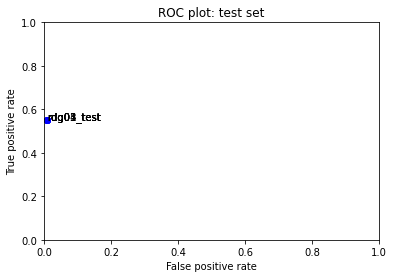

In [82]:
#fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

fits = [rdg01_performance_test,rdg02_performance_test,rdg03_performance_test,rdg04_performance_test,rdg05_performance_test]
for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='toxiccomments_test.csv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 189775)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6       

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.48613904050560186


In [25]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [26]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,True
2,00013b17ad220c46,True
3,00017563c3f7919a,True
4,00017695ad8997eb,True


In [27]:
my_submission.shape

(153164, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation